In [31]:
import matplotlib.pyplot as plt

class Location:
    def __init__(self, infection_rate):
        self.infection_rate = infection_rate

class Person:
    def __init__(self, location, infected=False):
        self.location = location
        self.recovery_prob = 0.8
        self.infected = infected

class Result:
    def __init__(self, day, location, num_susceptible, num_infected):
        self.day = day
        self.location = location
        self.num_susceptible = num_susceptible
        self.num_infected = num_infected
        
def count_people(people, location, infected):
    return len(list(filter(lambda person: person.location == location and person.infected == infected, people)))

def count_susceptible(people, location):
    return count_people(people, location, False)

def count_infected(people, location):
    return count_people(people, location, True)

def simulate(people, locations, num_days):
    results = []
    for day in range(num_days):
        for location in locations:
            people_in_location = list(filter(lambda person: person.location == location), people)
            # TODO: infect people
            num_susceptible = count_susceptible(people, location)
            num_infected = count_infected(people, location)
            result = Result(day, location, num_susceptible, num_infected)
            results.append(result)
    return results

# List of results -> Plot or list of plots
def plot_results(results, num_days):
    infected_counts = []
    for day in range(num_days):
        num_infected = sum(result.num_infected for result in results if result.day == day)
        infected_counts.append(num_infected)
    fig, axes = plt.subplots()
    axes.plot(infected_counts)

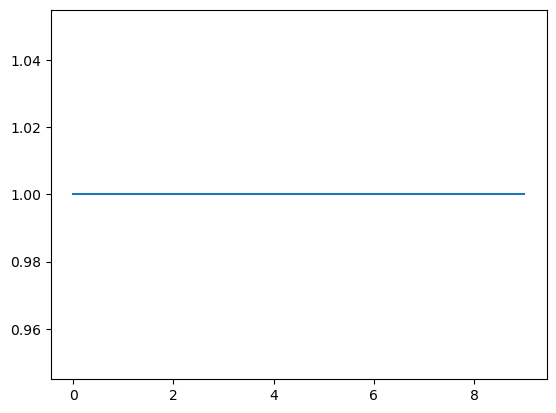

In [34]:
locations = [Location(0.1)]
people = [Person(locations[0], True), Person(locations[0])]
num_days = 10
results = simulate(people, locations, num_days)
plot_results(results, num_days)